In [ ]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
TRAIN_DIR = "./cats_and_dogs_filtered/train"
VAL_DIR = "./cats_and_dogs_filtered/validation"

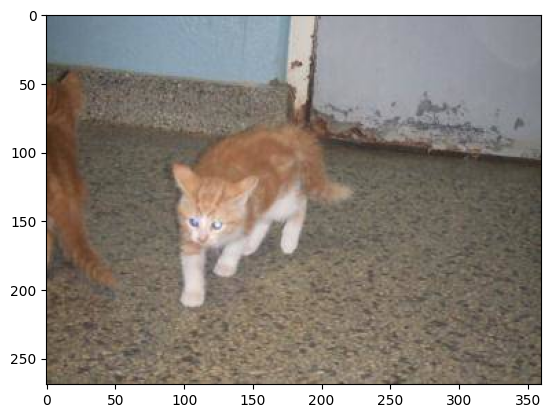

In [ ]:
label = "cats"
train_sample_fn = os.listdir(os.path.join(TRAIN_DIR, label))[0]
train_sample_path = os.path.join(TRAIN_DIR, label, train_sample_fn)

img = Image.open(train_sample_path)
img_data = np.asarray(img)
plt.imshow(img_data);

In [ ]:
IMG_SIZE = (224, 224)
INP_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

def gen_new_data(data_folder, augmented=True):
  if augmented:
    data_gen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
  else:
    data_gen = ImageDataGenerator(rescale=1./255)

  data = data_gen.flow_from_directory(
      data_folder,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode="binary",
  )
  return data

In [ ]:
INP_SHAPE

(224, 224, 3)

In [ ]:
ds_train = gen_new_data(TRAIN_DIR, augmented=True)
ds_val = gen_new_data(VAL_DIR, augmented=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing

## ResNet

In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

resnet = Sequential()
resnet.add(Resizing(224, 224, input_shape=INP_SHAPE))
resnet.add(hub.KerasLayer(resnet_url, trainable=False))
resnet.add(Dense(1, activation="sigmoid"))
resnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
INP_SHAPE

(224, 224, 3)

In [ ]:
resnet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
resnet_history = resnet.fit(ds_train, epochs=15, validation_data=ds_val)

Epoch 1/15
32/32 [==============================] - 37s 849ms/step - loss: 0.2389 - acc: 0.9085 - val_loss: 0.0967 - val_acc: 0.9750
Epoch 2/15
32/32 [==============================] - 25s 771ms/step - loss: 0.0941 - acc: 0.9705 - val_loss: 0.0523 - val_acc: 0.9850
Epoch 3/15
32/32 [==============================] - 25s 776ms/step - loss: 0.0731 - acc: 0.9740 - val_loss: 0.0395 - val_acc: 0.9850
Epoch 4/15
32/32 [==============================] - 25s 781ms/step - loss: 0.0622 - acc: 0.9750 - val_loss: 0.0338 - val_acc: 0.9880
Epoch 5/15
32/32 [==============================] - 25s 777ms/step - loss: 0.0564 - acc: 0.9805 - val_loss: 0.0295 - val_acc: 0.9880
Epoch 6/15
32/32 [==============================] - 25s 775ms/step - loss: 0.0499 - acc: 0.9805 - val_loss: 0.0281 - val_acc: 0.9890
Epoch 7/15
32/32 [==============================] - 25s 779ms/step - loss: 0.0475 - acc: 0.9840 - val_loss: 0.0285 - val_acc: 0.9900
Epoch 8/15
32/32 [==============================] - 25s 783ms/step - 

## MobileNetV2

In [ ]:
from tensorflow.keras.layers import InputLayer


In [ ]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

mobilenet = Sequential()
mobilenet.add(InputLayer(input_shape=INP_SHAPE))
mobilenet.add(hub.KerasLayer(mobilenet_url, trainable=False))
mobilenet.add(Dense(1, activation="sigmoid"))
mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
mobilenet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
mobilenet_history = mobilenet.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
32/32 [==============================] - 30s 812ms/step - loss: 0.3227 - acc: 0.8820 - val_loss: 0.1406 - val_acc: 0.9740
Epoch 2/20
32/32 [==============================] - 25s 787ms/step - loss: 0.1440 - acc: 0.9540 - val_loss: 0.0784 - val_acc: 0.9830
Epoch 3/20
32/32 [==============================] - 25s 794ms/step - loss: 0.1052 - acc: 0.9670 - val_loss: 0.0630 - val_acc: 0.9800
Epoch 4/20
32/32 [==============================] - 26s 798ms/step - loss: 0.0838 - acc: 0.9705 - val_loss: 0.0548 - val_acc: 0.9820
Epoch 5/20
32/32 [==============================] - 26s 807ms/step - loss: 0.0816 - acc: 0.9685 - val_loss: 0.0471 - val_acc: 0.9870
Epoch 6/20
32/32 [==============================] - 26s 805ms/step - loss: 0.0745 - acc: 0.9725 - val_loss: 0.0440 - val_acc: 0.9870
Epoch 7/20
32/32 [==============================] - 25s 791ms/step - loss: 0.0756 - acc: 0.9740 - val_loss: 0.0428 - val_acc: 0.9870
Epoch 8/20
32/32 [==============================] - 26s 825ms/step - 

In [ ]:
mobilenet.save('mobilenet.h5')

## Inception Net

In [ ]:
inceptionnet_url = "https://tfhub.dev/google/imagenet/inception_v3/classification/4"

inceptionnet = Sequential()
inceptionnet.add(InputLayer(input_shape=INP_SHAPE))
inceptionnet.add(hub.KerasLayer(mobilenet_url, trainable=False))
inceptionnet.add(Dense(1, activation="sigmoid"))
inceptionnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
inceptionnet.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

In [ ]:
inceptionnet_history = inceptionnet.fit(ds_train, epochs=15, validation_data=ds_val)

Epoch 1/15
32/32 [==============================] - 31s 850ms/step - loss: 0.3643 - acc: 0.8555 - val_loss: 0.1406 - val_acc: 0.9730
Epoch 2/15
32/32 [==============================] - 27s 834ms/step - loss: 0.1488 - acc: 0.9510 - val_loss: 0.0888 - val_acc: 0.9760
Epoch 3/15
32/32 [==============================] - 25s 793ms/step - loss: 0.1101 - acc: 0.9635 - val_loss: 0.0712 - val_acc: 0.9840
Epoch 4/15
32/32 [==============================] - 25s 768ms/step - loss: 0.1034 - acc: 0.9650 - val_loss: 0.0621 - val_acc: 0.9840
Epoch 5/15
32/32 [==============================] - 25s 765ms/step - loss: 0.0944 - acc: 0.9670 - val_loss: 0.0624 - val_acc: 0.9800
Epoch 6/15
32/32 [==============================] - 24s 765ms/step - loss: 0.0851 - acc: 0.9685 - val_loss: 0.0558 - val_acc: 0.9840
Epoch 7/15
32/32 [==============================] - 24s 755ms/step - loss: 0.0771 - acc: 0.9745 - val_loss: 0.0494 - val_acc: 0.9880
Epoch 8/15
32/32 [==============================] - 25s 786ms/step - 

In [ ]:
import numpy as np
import sklearn
x = np.array([2, 0, 0])
y = np.array([2, 0, 4])
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(x, y)

ValueError: ignored

In [ ]:
import numpy as np
import sklearn
x = np.array([1, 1, 0])
y = np.array([1, 1, 1, 1])
x.dot(y) / (np.sqrt(sum(x**2)) * np.sqrt(sum(y**2)))

In [ ]:
3 / (np.sqrt(10) * (np.sqrt(3)))